In [14]:
%load_ext ipydex.displaytools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/brandonhosley/Documents/GitHub/Schoolwork/2023Q2 - Statistical Machine Learning/Project')
import ProjectFunctions as PF

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


In [15]:
df = pd.read_csv('../../Datasets/diabetes_data.csv')
df.head()

label = 'Diabetes'
fields=['Rho','Imbalance Technique','Classifier','Training f1','Test f1',
        'Runtime','Minority Count','k','n-Estimators','MaxDepth','MaxFeatures']

df = PF.scrub_diabetes(df)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
filename = 'UndersamplingTechniques.csv'
#### PF.newFile(filename, fields)

#PF.baseline
# PF.Undersample, PF.OneSided,PF.Near_Miss, PF.Tomek_Links
#PF.Oversample, PF.smote,  PF.borderline_smote

for tech in [PF.Near_Miss]:  
    for classifier in [PF.KNN, PF.DecisionTree ]: # , PF.ExtraTrees, PF.RandomForest , , 
        for _ in range(10):
            for i in list(range(3,10,2))+list(range(10,99,10))+list(range(100,501,25)):
                PF.test(df, i, tech, classifier, fields, filename=filename)



Visualizing the Undersampling

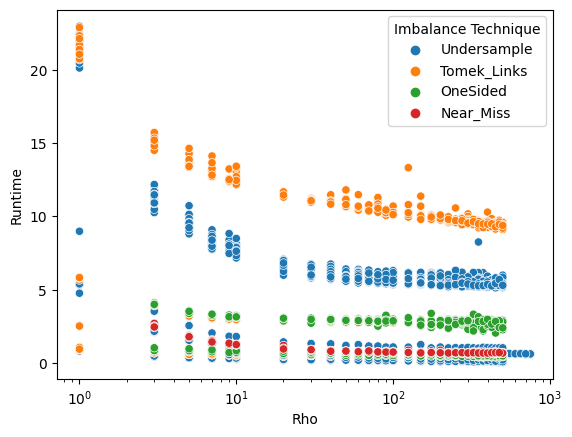

In [28]:
tr = pd.read_csv('UndersamplingTechniques.csv')

sns.scatterplot(x='Rho',y='Runtime', hue='Imbalance Technique', data=tr)
plt.xscale('log')

(0.0, 25.0)

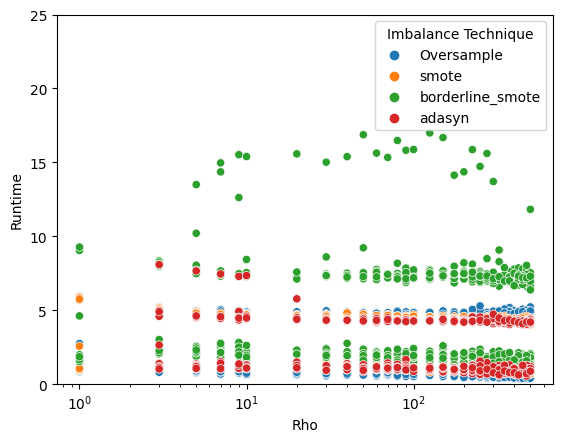

In [27]:
tr = pd.read_csv('OversamplingTechniques.csv')

sns.scatterplot(x='Rho',y='Runtime', hue='Imbalance Technique', data=tr)
plt.xscale('log')
plt.ylim(0, 25)

In [16]:
usTech = pd.read_csv('UndersamplingTechniques.csv')
osTech = pd.read_csv('OversamplingTechniques.csv')
df = pd.concat([usTech,osTech])

In [19]:
df.head()

,Rho,Imbalance Technique,Classifier,Training f1,Test f1,Runtime,Minority Count,k,n-Estimators,MaxDepth,MaxFeatures
0,1,Undersample,KNN,0.717868,0.710746,5.532803,35346,19.0,NaN,NaN,NaN
1,3,Undersample,KNN,0.713441,0.543843,2.234577,11782,19.0,NaN,NaN,NaN
2,5,Undersample,KNN,0.711179,0.446956,1.576110,7069,15.0,NaN,NaN,NaN
3,7,Undersample,KNN,0.717744,0.366165,1.307612,5049,13.0,NaN,NaN,NaN
4,9,Undersample,KNN,0.697179,0.310134,1.178377,3927,13.0,NaN,NaN,NaN


In [20]:
sum(df.Runtime)

19304.34428548813